# Baseline Code for Deepfake Detection


By Dongmin Kim

## Data Setups

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import sys, os
import pandas as pd
from contextlib import contextmanager
tf.compat.v1.disable_eager_execution()
np.random.seed(42)

In [2]:
gpu_id = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)
physical_devices = tf.config.experimental.get_visible_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.test.is_gpu_available()

True

## Training

In [5]:
BGR = lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [6]:
VALID_RATIO = 0.1
TEST_RATIO = 0.1
BATCH_SIZE = 32
EPOCHS = 100
TOTAL_DATA_SIZE = 20000

In [7]:
data_gen_args = dict(
    rescale=1./255, 
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.1, 
    zoom_range=0.1, 
    horizontal_flip=True, 
    fill_mode='nearest',
    validation_split = VALID_RATIO,
)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **data_gen_args,
    preprocessing_function = BGR
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    preprocessing_function = BGR
)

In [8]:
seed = 42
#path = "/media/data1/hsm/FACE_FORENSICS_C40/DATA_FRAMES/"
path = "./TK_diff"
real_data_dir = os.path.join(path, 'REAL')
fake_data_dir = os.path.join(path, 'FAKE', 'NeuralTextures')

real_filenames = np.array([os.path.join('REAL', f) for f in os.listdir(real_data_dir)])
fake_filenames = np.array([os.path.join('FAKE', 'NeuralTextures', f) for f in os.listdir(fake_data_dir)])

print("FROM DIR")
print("REAL: ", len(real_filenames))
print("FAKE: ", len(fake_filenames))
print("TOTAL: ", len(real_filenames) + len(fake_filenames))

FROM DIR
REAL:  10000
FAKE:  10000
TOTAL:  20000


In [9]:
# random sampling
real_filenames = np.random.choice(real_filenames, TOTAL_DATA_SIZE//2, replace = False).tolist()
fake_filenames = np.random.choice(fake_filenames, TOTAL_DATA_SIZE//2, replace = False).tolist()

In [10]:
print("TRIM SIZE")
print("REAL: ", len(real_filenames))
print("FAKE: ", len(fake_filenames))
print("TOTAL: ", len(real_filenames) + len(fake_filenames))

total_length = len(real_filenames) + len(fake_filenames)

test_length = int(total_length * TEST_RATIO)
validation_length = int((total_length-test_length) * VALID_RATIO)
train_length = total_length - validation_length - test_length

print("TRAIN: ", train_length, "VALIDATION: ", validation_length, "TEST: ", test_length)

TRIM SIZE
REAL:  10000
FAKE:  10000
TOTAL:  20000
TRAIN:  16200 VALIDATION:  1800 TEST:  2000


## Test Dataset Separation

In [11]:
import cv2

In [12]:
real_filenames_test = real_filenames[:test_length//2]
fake_filenames_test = fake_filenames[:test_length//2]
real_filenames = real_filenames[test_length//2:]
fake_filenames = fake_filenames[test_length//2:]

In [13]:
real_categories_test = []
for filename in real_filenames_test:
    real_categories_test.append('0')
        
real_testdata = pd.DataFrame({'filename' : real_filenames_test, 'label' : real_categories_test})

In [14]:
fake_categories_test = []
for filename in fake_filenames_test:
    fake_categories_test.append('1')

fake_testdata = pd.DataFrame({'filename' : fake_filenames_test, 'label' : fake_categories_test})

In [15]:
test_data = pd.concat([real_testdata, fake_testdata])

In [16]:
# real : 0, fake : 1
categories = []
for filename in real_filenames:
    categories.append('0')
    
for filename in fake_filenames:
    categories.append('1')

In [17]:
data = pd.DataFrame({'filename' : real_filenames + fake_filenames, 'label' : categories})

In [18]:
data

,filename,label
0,REAL/16__podium_speech_happy_frame1145.jpg,0
1,REAL/11__talking_against_wall_frame30.jpg,0
2,REAL/133_frame456.jpg,0
3,REAL/05__talking_against_wall_frame300.jpg,0
4,REAL/672_frame354.jpg,0
...,...,...
17995,FAKE/NeuralTextures/211_177_frame120.jpg,1
17996,FAKE/NeuralTextures/727_729_frame370.jpg,1
17997,FAKE/NeuralTextures/314_347_frame318.jpg,1
17998,FAKE/NeuralTextures/546_621_frame210.jpg,1


In [19]:
data = data.iloc[np.random.RandomState(seed = 42).permutation(len(data))]

In [20]:
data

,filename,label
2574,REAL/794_frame430.jpg,0
7496,REAL/540_frame170.jpg,0
9210,FAKE/NeuralTextures/104_126_frame78.jpg,1
5456,REAL/01__kitchen_still_frame250.jpg,0
736,REAL/241_frame210.jpg,0
...,...,...
11284,FAKE/NeuralTextures/234_187_frame102.jpg,1
11964,FAKE/NeuralTextures/118_120_frame125.jpg,1
5390,REAL/744_frame84.jpg,0
860,REAL/074_frame35.jpg,0


In [21]:
test_data

,filename,label
0,REAL/07__talking_angry_couch_frame1500.jpg,0
1,REAL/385_frame72.jpg,0
2,REAL/06__walk_down_hall_angry_frame20.jpg,0
3,REAL/825_frame420.jpg,0
4,REAL/994_frame25.jpg,0
...,...,...
995,FAKE/NeuralTextures/949_868_frame72.jpg,1
996,FAKE/NeuralTextures/579_701_frame96.jpg,1
997,FAKE/NeuralTextures/271_264_frame90.jpg,1
998,FAKE/NeuralTextures/712_716_frame340.jpg,1


In [22]:
test_data.groupby(['label']).size()

label
0    1000
1    1000
dtype: int64

In [23]:
train_generator = datagen.flow_from_dataframe(
    dataframe = data,
    directory = path,
    x_col = 'filename',
    y_col = 'label',
    target_size =(256, 256),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    shuffle = True,
    subset = 'training'
)


validation_generator = datagen.flow_from_dataframe(
    dataframe = data,
    directory = path,
    x_col = 'filename',
    y_col = 'label',
    target_size =(256, 256),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    shuffle = True,
    subset = 'validation'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = path,
    x_col = 'filename',
    y_col = 'label',
    target_size =(256, 256),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
)

Found 16200 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [24]:
# import available models for training
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Dropout
import efficientnet.tfkeras as efn
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception

In [25]:
def setupmodel():
    input_tensor = Input(shape = (256,256,3))

    base_model = Xception(
    weights = 'imagenet',
    include_top = False,
    input_tensor = input_tensor
    )
    # Setup
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation = "relu")(x)
    prediction = Dense(1, activation="sigmoid")(x)

    # model return
    model = Model(base_model.input, prediction)

    # trainable
    for l in base_model.layers:
        l.trainable = True

    return model

In [26]:
model = setupmodel()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K

In [29]:
class CyclicLR(tf.keras.callbacks.Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [30]:
def train_model(model, train_generator, validation_generator, test_generator, optimizer):
    # checkpointing
    filename = 'checkpoint-TK_diff-smalldata.h5'
    checkpoint = ModelCheckpoint(
                        filename, 
                        monitor='val_loss',
                        verbose=1,           
                        save_best_only=True,
                        mode='auto'
                )
    # early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    
    # Cyclic Learning Rate
    clr = CyclicLR(
        base_lr=1e-3,#0.001, 
        max_lr=7e-3,#0.007,
        step_size=300., 
        mode='exp_range',
        gamma=0.99994
    )
    
    # compile
    model.compile(
        optimizer = optimizer,
        loss = 'binary_crossentropy',
        metrics=['accuracy'],
    )
    
    # train
    print("== Start Training ==")
    history = model.fit(
        train_generator,
        steps_per_epoch = train_length // BATCH_SIZE, 
        epochs = EPOCHS,
        validation_data = validation_generator,
        validation_steps = validation_length // BATCH_SIZE,
        callbacks=[checkpoint, clr],
    )
    
    return history

In [31]:
history = train_model(model, train_generator, validation_generator, test_generator, tf.keras.optimizers.Adam(lr = 1e-3))

== Start Training ==
Epoch 1/100
505/506 [============================>.] - ETA: 0s - loss: 0.7499 - accuracy: 0.5007
Epoch 00001: val_loss improved from inf to 0.68830, saving model to checkpoint-TK_diff-smalldata.h5
506/506 [==============================] - 394s 779ms/step - loss: 0.7498 - accuracy: 0.5008 - val_loss: 0.6883 - val_accuracy: 0.5234
Epoch 2/100
505/506 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5258
Epoch 00002: val_loss did not improve from 0.68830
506/506 [==============================] - 328s 649ms/step - loss: 0.6870 - accuracy: 0.5258 - val_loss: 0.7183 - val_accuracy: 0.5184
Epoch 3/100
505/506 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.5174
Epoch 00003: val_loss did not improve from 0.68830
506/506 [==============================] - 328s 648ms/step - loss: 0.6871 - accuracy: 0.5174 - val_loss: 0.6930 - val_accuracy: 0.4894
Epoch 4/100
505/506 [============================>.] - ETA: 0s - loss: 0.6887 - a

505/506 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5064
Epoch 00029: val_loss did not improve from 0.67874
506/506 [==============================] - 320s 632ms/step - loss: 0.6932 - accuracy: 0.5065 - val_loss: 0.6932 - val_accuracy: 0.5100
Epoch 30/100
505/506 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5117
Epoch 00030: val_loss did not improve from 0.67874
506/506 [==============================] - 318s 628ms/step - loss: 0.6931 - accuracy: 0.5114 - val_loss: 0.6925 - val_accuracy: 0.5112
Epoch 31/100
505/506 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5052
Epoch 00031: val_loss did not improve from 0.67874
506/506 [==============================] - 321s 634ms/step - loss: 0.6928 - accuracy: 0.5054 - val_loss: 0.6929 - val_accuracy: 0.5089
Epoch 32/100
505/506 [============================>.] - ETA: 0s - loss: 0.6944 - accuracy: 0.5093
Epoch 00032: val_loss did not improve from 0.67874
506/506 [===

505/506 [============================>.] - ETA: 0s - loss: 0.6517 - accuracy: 0.5973
Epoch 00057: val_loss improved from 0.65155 to 0.64464, saving model to checkpoint-TK_diff-smalldata.h5
506/506 [==============================] - 308s 608ms/step - loss: 0.6516 - accuracy: 0.5975 - val_loss: 0.6446 - val_accuracy: 0.5943
Epoch 58/100
505/506 [============================>.] - ETA: 0s - loss: 0.6494 - accuracy: 0.5972
Epoch 00058: val_loss did not improve from 0.64464
506/506 [==============================] - 316s 625ms/step - loss: 0.6493 - accuracy: 0.5974 - val_loss: 0.6454 - val_accuracy: 0.5965
Epoch 59/100
505/506 [============================>.] - ETA: 0s - loss: 0.6444 - accuracy: 0.6028
Epoch 00059: val_loss did not improve from 0.64464
506/506 [==============================] - 316s 625ms/step - loss: 0.6443 - accuracy: 0.6030 - val_loss: 0.6542 - val_accuracy: 0.5848
Epoch 60/100
505/506 [============================>.] - ETA: 0s - loss: 0.6475 - accuracy: 0.6021
Epoch 0006

505/506 [============================>.] - ETA: 0s - loss: 0.5917 - accuracy: 0.6655
Epoch 00084: val_loss did not improve from 0.59298
506/506 [==============================] - 312s 616ms/step - loss: 0.5918 - accuracy: 0.6655 - val_loss: 0.5994 - val_accuracy: 0.6602
Epoch 85/100
505/506 [============================>.] - ETA: 0s - loss: 0.5868 - accuracy: 0.6717
Epoch 00085: val_loss did not improve from 0.59298
506/506 [==============================] - 311s 615ms/step - loss: 0.5869 - accuracy: 0.6717 - val_loss: 0.6347 - val_accuracy: 0.6406
Epoch 86/100
505/506 [============================>.] - ETA: 0s - loss: 0.5800 - accuracy: 0.6769
Epoch 00086: val_loss improved from 0.59298 to 0.59062, saving model to checkpoint-TK_diff-smalldata.h5
506/506 [==============================] - 313s 619ms/step - loss: 0.5798 - accuracy: 0.6771 - val_loss: 0.5906 - val_accuracy: 0.6735
Epoch 87/100
505/506 [============================>.] - ETA: 0s - loss: 0.5808 - accuracy: 0.6797
Epoch 0008

**Plot Results**

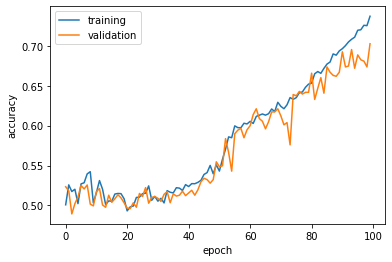

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

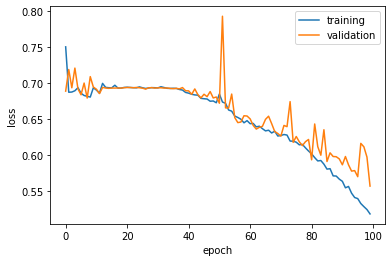

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

In [34]:
model = setupmodel()
json_filename = "TK_diff_model.json"

In [35]:
model_json = model.to_json()
with open(json_filename, "w") as json_file : 
    json_file.write(model_json)

In [36]:
from tensorflow.keras.models import model_from_json 
json_file = open(json_filename, "r") 
loaded_model_json = json_file.read() 
json_file.close() 
loaded_model = model_from_json(loaded_model_json)

In [37]:
loaded_model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = 1e-3),
    loss = 'binary_crossentropy',
    metrics=['accuracy'],
)
loaded_model.load_weights("checkpoint-TK_diff-smalldata.h5")

### Metrics - F1, Recall, Precision

In [38]:
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from tqdm import tqdm, trange

In [39]:
print("== Evaluate ==")

output_score = []
output_class = []
answer_class = []

for i in trange(len(test_generator)):
    output = loaded_model.predict_on_batch(test_generator[i][0])
    output_score.append(output)
    answer_class.append(test_generator[i][1])
    
output_score = np.concatenate(output_score)
answer_class = np.concatenate(answer_class)

lst = []
for i in output_score:
    val = i[0]
    sublst = [1-val, val]
    lst.append(sublst)
    
output_score = np.array(lst)

print(output_score)
print(answer_class)

output_class = np.argmax(output_score, axis=1)

print(output_class)
print(answer_class)

  0%|          | 0/63 [00:00<?, ?it/s]

== Evaluate ==


100%|██████████| 63/63 [00:19<00:00,  3.30it/s]

[[0.41786373 0.58213627]
 [0.98802307 0.01197693]
 [0.22547168 0.77452832]
 ...
 [0.57173094 0.42826906]
 [0.1711973  0.8288027 ]
 [0.45964557 0.54035443]]
[1. 0. 0. ... 0. 1. 1.]
[1 0 1 ... 0 1 1]
[1. 0. 0. ... 0. 1. 1.]


In [40]:
print(len(answer_class))

cnt = np.sum(answer_class)
print(cnt)

print(len(output_class))
cnt2= np.sum(output_class)
print(cnt2)

2000
1000.0
2000
1210


In [41]:
cm = confusion_matrix(answer_class, output_class)
report = classification_report(answer_class, output_class)

recall = cm[0][0] / (cm[0][0] + cm[0][1])
fallout = cm[1][0] / (cm[1][0] + cm[1][1])

fpr, tpr, thresholds = roc_curve(answer_class, output_score[:, 1], pos_label=1.)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)

print(report)
print(cm)
print("AUROC: %f" %(roc_auc_score(answer_class, output_score[:, 1])))
print("THRESH: " , thresh)
print('test_acc: ', len(output_class[np.equal(output_class, answer_class)]) / len(output_class))

              precision    recall  f1-score   support

         0.0       0.76      0.60      0.67      1000
         1.0       0.67      0.81      0.74      1000

    accuracy                           0.71      2000
   macro avg       0.72      0.71      0.70      2000
weighted avg       0.72      0.71      0.70      2000

[[603 397]
 [187 813]]
AUROC: 0.782390
THRESH:  0.6285647153854199
test_acc:  0.708
